In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from matplotlib import pyplot as plt
from pylab import rcParams
import sklearn
from sklearn.linear_model import LinearRegression
import talib
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MaxAbsScaler
import time
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.metrics import *
import os
import tensorflow as tf
import tensorflow_addons as tfa 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
import optuna

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

<h1 style="font-size:40px;"> <center> FUNCTIONS </center> </h1>

In [3]:
SEED = 42


def set_random_seed():
    tf.keras.utils.set_random_seed(
    SEED
)
    

def HMA(df:pd.DataFrame, timeperiod:int= 14) -> float:
    """
    Hull Moving Average.
    Formula:
    HMA = WMA(2*WMA(n/2) - WMA(n)), sqrt(n)
    """
    hma = talib.WMA(2 * talib.WMA(df, int(timeperiod/2)) - talib.WMA(df, timeperiod), int(np.sqrt(timeperiod)))
    return hma


def money_flow_volume_series(df: pd.DataFrame) -> pd.Series:
    """
    Calculates money flow series
    """
    mfv = df['Volume'] * (2*df['Close'] - df['High'] - df['Low']) / \
                                    (df['High'] - df['Low'])
    return mfv


def money_flow_volume(df: pd.DataFrame, timeperiod: int=20) -> pd.Series:
    """
    Calculates money flow volume, or q_t in our formula
    """
    return money_flow_volume_series(df).rolling(timeperiod).sum()


def CMF(df: pd.DataFrame, timeperiod: int=20) -> pd.Series:
    """
    Calculates the Chaikin money flow
    """
    return money_flow_volume(df, timeperiod) / df['Volume'].rolling(timeperiod).sum()


def pltcolor(lst:list) -> list:
    cols=[]
    for i in range(lst.shape[0]):
        if lst.iloc[i] == 1:
            cols.append('green')
        elif lst.iloc[i] == 2:
            cols.append('red')
    return cols
     

def trendNormalizePrices(prices:pd.DataFrame) -> None:
    df = prices.copy()
    df["rowNumber"] = list(range(len(df)))
    df["TN_Open"] = list(range(len(df)))
    df["TN_High"] = list(range(len(df)))
    df["TN_Low"] = list(range(len(df)))
    df["TN_Close"] = list(range(len(df)))
    for i in range(29,len(df)):
        model = LinearRegression()
        model.fit(np.array(df["rowNumber"].iloc[i-29:i+1]).reshape(-1,1), np.array(df["Close"].iloc[i-29:i+1]))
        prediction = model.predict(np.array([df["rowNumber"].iloc[i]]).reshape(-1,1))
        df.iloc[i, df.columns.get_loc("TN_Open")] = df["Open"].iloc[i] - prediction 
        df.iloc[i, df.columns.get_loc("TN_High")] = df["High"].iloc[i] - prediction 
        df.iloc[i, df.columns.get_loc("TN_Low")] = df["Low"].iloc[i] - prediction 
        df.iloc[i, df.columns.get_loc("TN_Close")] = df["Close"].iloc[i] - prediction 
    df["Open"] = df["TN_Open"] 
    df["High"] = df["TN_High"]
    df["Low"] = df["TN_Low"]
    df["Close"] = df["TN_Close"]
    df = df.drop(index=df.index[:30], axis=0)
    df = df.drop(columns=["TN_Open", "TN_High", "TN_Low", "TN_Close", "rowNumber"], axis=1)
    return df
    
    
def create_labels(prices:pd.DataFrame) -> None:
    df = prices.copy()
    df["Label"] = [0] * df.shape[0]
    for i in range(df.shape[0]-10):
        s = set(df["Close"].iloc[i:i+11]) 
        minPrice = sorted(s)[0]
        maxPrice = sorted(s)[-1]
        for j in range(i, i+11):
            if df["Close"].iloc[j] == minPrice and (j-i) == 5:
                df.iloc[j, df.columns.get_loc('Label')] = 1
            elif df["Close"].iloc[j] == maxPrice and (j-i) == 5:
                df.iloc[j, df.columns.get_loc('Label')] = 2
    return df.iloc[6:-6]
                
                
def reverse_one_hot(predictions:np.array) -> np.array:
    return np.argmax(predictions, axis=1)


def one_hot(predictions:np.array) -> np.array:
    predictions_one_hot = []
    for i in predictions:
        prediction = [0,0,0]
        prediction[int(i)] = 1
        predictions_one_hot.append(prediction)   
    return np.array(predictions_one_hot)


def number_null_and_nan(df:pd.DataFrame) -> int:
    na = pd.isna(df).sum().sum()
    null = df.isnull().sum().sum()
    return (na+null) 

<h1 style="font-size:40px;"> <center> DATA PREPROCESSING </center> </h1>

In [4]:
prices = yf.download("SPY", start="2009-09-20", end="2023-01-01", interval="1d", progress=False, auto_adjust=True)
prices

,Open,High,Low,Close,Volume
Date,,,,,
2009-09-21 00:00:00-04:00,82.204735,83.066452,82.026184,82.639473,151892000
2009-09-22 00:00:00-04:00,83.128523,83.353657,82.755886,83.120758,143126700
2009-09-23 00:00:00-04:00,83.314831,83.866019,82.282322,82.429825,225947400
2009-09-24 00:00:00-04:00,82.608389,82.786940,81.164431,81.521538,228636800
2009-09-25 00:00:00-04:00,81.342987,81.793255,80.807323,81.086800,204059000
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,379.649994,383.059998,378.029999,382.910004,59857300
2022-12-27 00:00:00-05:00,382.790009,383.149994,379.649994,381.399994,51638200
2022-12-28 00:00:00-05:00,381.329987,383.390015,376.420013,376.660004,70911500


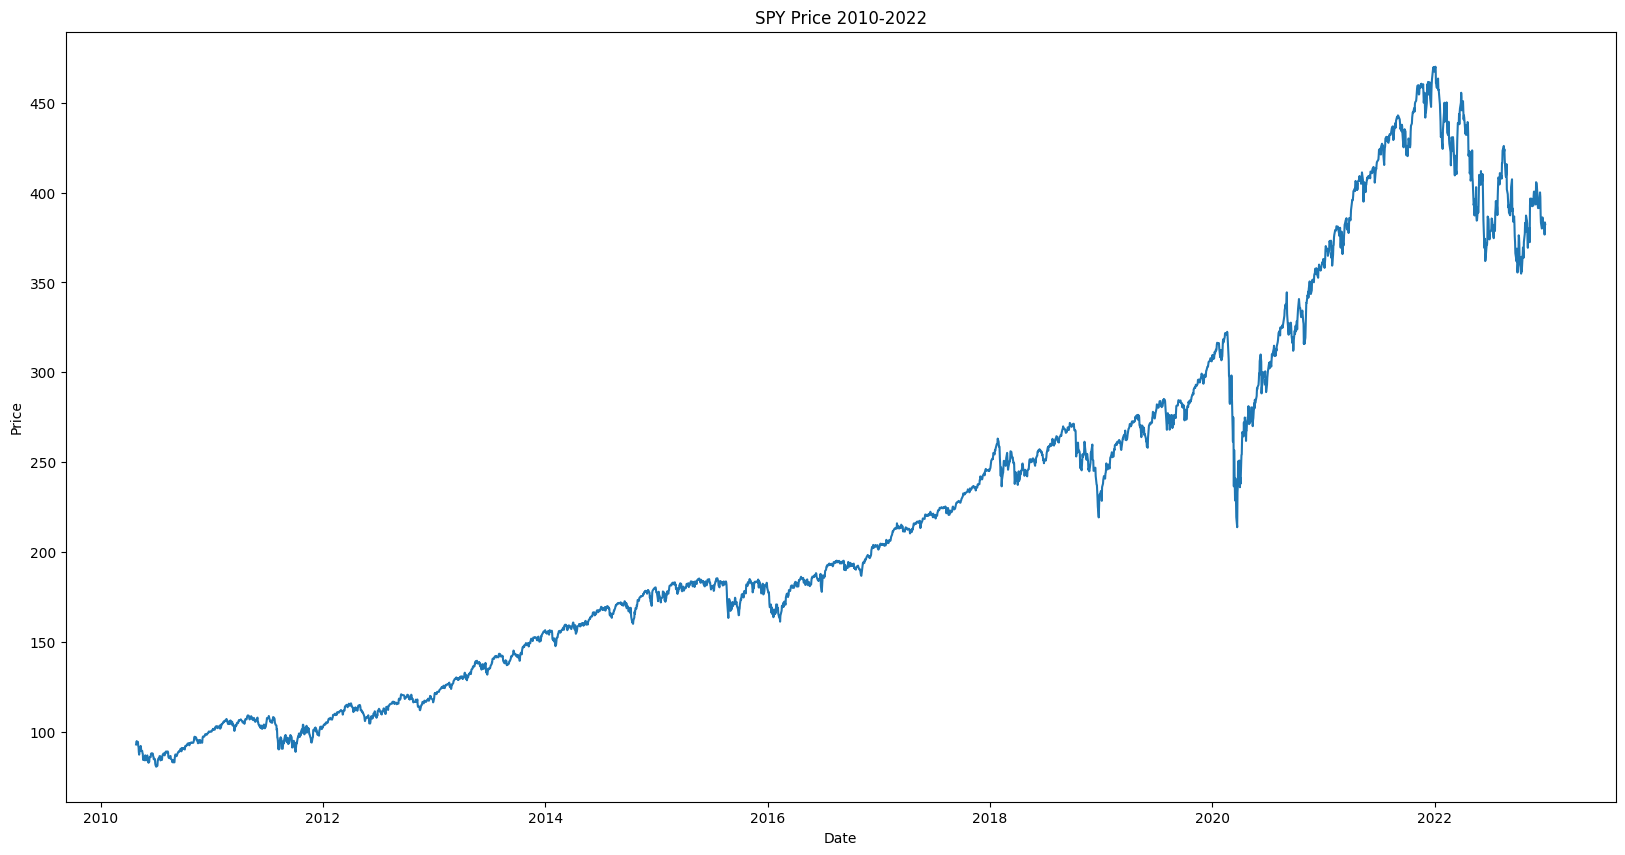

In [5]:
plt.figure(figsize=(20,10))
plt.title("SPY Price 2010-2022")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(prices[["Close"]].iloc[150:,:])

<h1 style="font-size:30px;"> <center> Trend Normalize and Visualize </center> </h1>

In [7]:
tn_prices = trendNormalizePrices(prices)
tn_prices

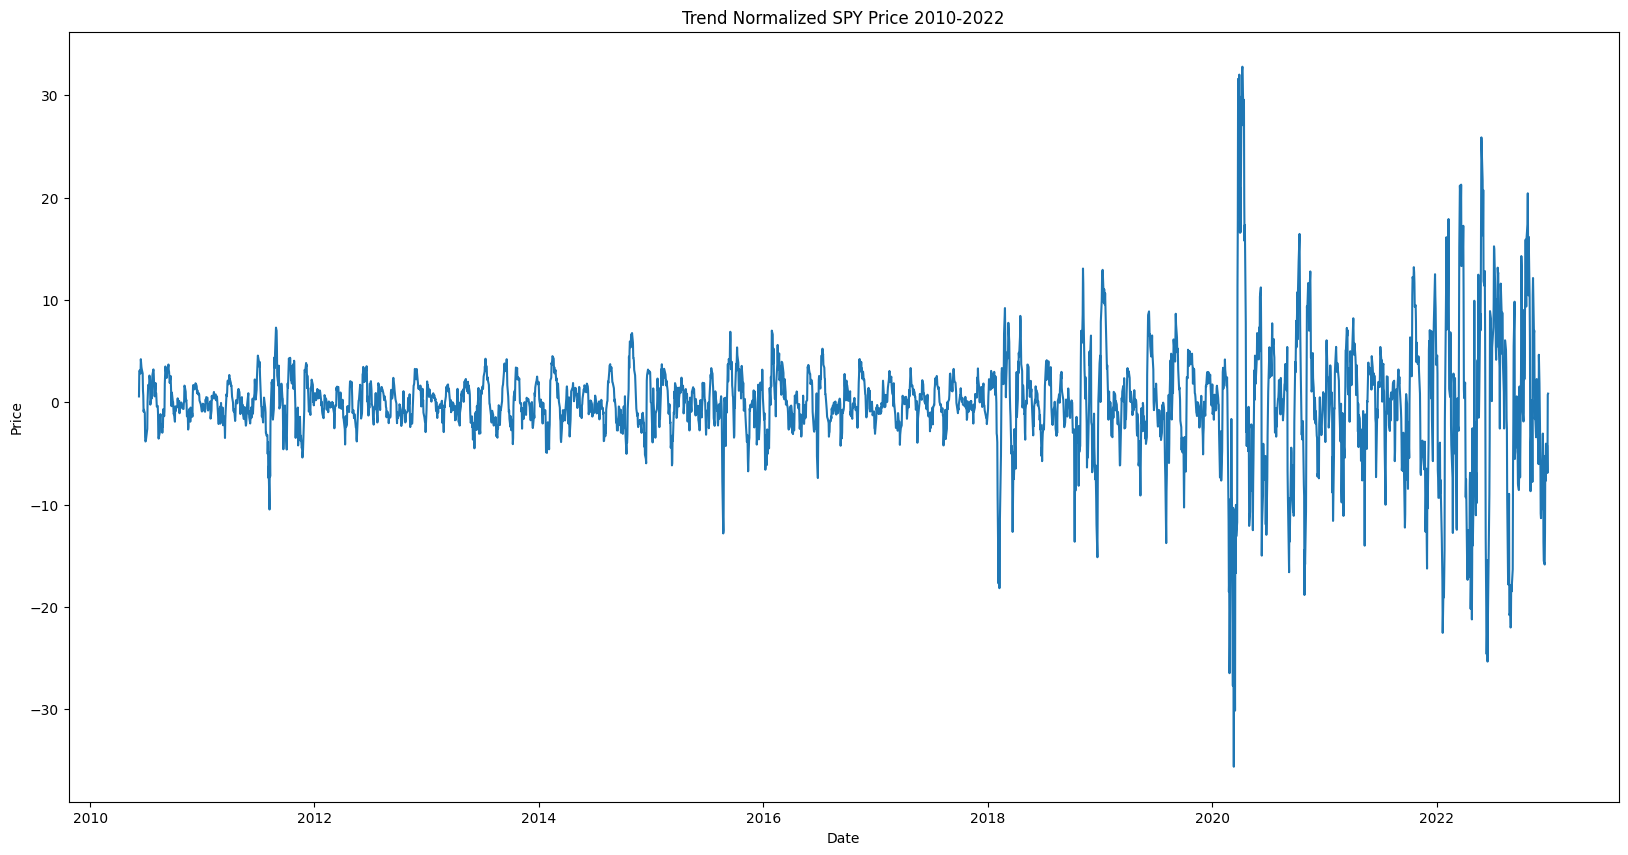

In [9]:
plt.figure(figsize=(20,10))
plt.title("Trend Normalized SPY Price 2010-2022")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(tn_prices[["Close"]].iloc[150:,:])

<h1 style="font-size:30px;"> <center> Adding Technical Indicators </center> </h1>

In [10]:
prices_and_indicators = tn_prices.copy()

In [11]:
for i in range(7,30):
    prices_and_indicators[f"RSI-{i}"] = talib.RSI(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"WILLR-{i}"] = talib.WILLR(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"STOCH-{i}"] = talib.STOCH(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], fastk_period=i+7, slowk_period=i-4)[0]
    prices_and_indicators[f"STOCHF-{i}"] = talib.STOCHF(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], fastk_period=i-2, fastd_period=i-4)[0]
    prices_and_indicators[f"SMA-{i}"] = talib.SMA(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"EMA-{i}"] = talib.EMA(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"WMA-{i}"] = talib.WMA(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"HMA-{i}"] = HMA(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"TEMA-{i}"] = talib.TEMA(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"PPO-{i}"] = talib.PPO(prices_and_indicators["Close"], fastperiod=i, slowperiod=i+14)
    prices_and_indicators[f"ROC-{i}"] = talib.ROC(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"CMO-{i}"] = talib.CMO(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"MACD-{i}"] = talib.MACD(prices_and_indicators["Close"], fastperiod=i, slowperiod=i+14)[0]
    prices_and_indicators[f"MAMA-{i}"] = talib.MAMA(prices_and_indicators["Close"], fastlimit=1/i, slowlimit=1/(i+14))[0]
    prices_and_indicators[f"STOCHRSI-{i}"] = talib.STOCHRSI(prices_and_indicators["Close"], timeperiod=i)[0]
    prices_and_indicators[f"DX-{i}"] = talib.DX(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"ADXR-{i}"] = talib.ADXR(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"CCI-{i}"] = talib.CCI(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"PLUS_DI-{i}"] = talib.PLUS_DI(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"MINUS_DI-{i}"] = talib.MINUS_DI(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"ATR-{i}"] = talib.ATR(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"SAR-{i}"] = talib.SAR(prices_and_indicators["High"],prices_and_indicators["Low"], maximum = 1/i)
    prices_and_indicators[f"PLUS_DM-{i}"] = talib.PLUS_DM(prices_and_indicators["High"],prices_and_indicators["Low"], timeperiod = i)
    prices_and_indicators[f"AROONOSC-{i}"] = talib.AROONOSC(prices_and_indicators["High"],prices_and_indicators["Low"], timeperiod = i)
    prices_and_indicators[f"MIDPRICE-{i}"] = talib.MIDPRICE(prices_and_indicators["High"],prices_and_indicators["Low"], timeperiod = i)
    prices_and_indicators[f"MFI-{i}"] = talib.MFI(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"],prices_and_indicators["Volume"], timeperiod = i)
    prices_and_indicators[f"ADOSC-{i}"] = talib.ADOSC(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"],prices_and_indicators["Volume"], fastperiod=i-4, slowperiod=i+3)
    prices_and_indicators[f"BBANDS-{i}"] = talib.BBANDS(prices_and_indicators["Close"], timeperiod = i)[1]
    prices_and_indicators[f"CMF-{i}"] = CMF(prices_and_indicators, timeperiod = i)
prices_and_indicators["BOP"] = talib.BOP(prices_and_indicators["Open"],prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"])
prices_and_indicators["TRANGE"] = talib.TRANGE(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"])    
prices_and_indicators["SAREXT"] = talib.SAREXT(prices_and_indicators["High"],prices_and_indicators["Low"])
prices_and_indicators["AD"] = talib.AD(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"],prices_and_indicators["Volume"])
prices_and_indicators["OBV"] = talib.OBV(prices_and_indicators["Close"],prices_and_indicators["Volume"])
prices_and_indicators.dropna(inplace = True)

C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once us

C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

In [12]:
prices_and_indicators

,Open,High,Low,Close,Volume,RSI-7,WILLR-7,STOCH-7,STOCHF-7,SMA-7,EMA-7,WMA-7,HMA-7,TEMA-7,PPO-7,ROC-7,CMO-7,MACD-7,MAMA-7,STOCHRSI-7,DX-7,ADXR-7,CCI-7,PLUS_DI-7,MINUS_DI-7,ATR-7,SAR-7,PLUS_DM-7,AROONOSC-7,MIDPRICE-7,MFI-7,ADOSC-7,BBANDS-7,CMF-7,RSI-8,WILLR-8,STOCH-8,STOCHF-8,SMA-8,EMA-8,WMA-8,HMA-8,TEMA-8,PPO-8,ROC-8,CMO-8,MACD-8,MAMA-8,STOCHRSI-8,DX-8,ADXR-8,CCI-8,PLUS_DI-8,MINUS_DI-8,ATR-8,SAR-8,PLUS_DM-8,AROONOSC-8,MIDPRICE-8,MFI-8,ADOSC-8,BBANDS-8,CMF-8,RSI-9,WILLR-9,STOCH-9,STOCHF-9,SMA-9,EMA-9,WMA-9,HMA-9,TEMA-9,PPO-9,ROC-9,CMO-9,MACD-9,MAMA-9,STOCHRSI-9,DX-9,ADXR-9,CCI-9,PLUS_DI-9,MINUS_DI-9,ATR-9,SAR-9,PLUS_DM-9,AROONOSC-9,MIDPRICE-9,MFI-9,ADOSC-9,BBANDS-9,CMF-9,RSI-10,WILLR-10,STOCH-10,STOCHF-10,SMA-10,EMA-10,WMA-10,HMA-10,TEMA-10,PPO-10,ROC-10,CMO-10,MACD-10,MAMA-10,STOCHRSI-10,DX-10,ADXR-10,CCI-10,PLUS_DI-10,MINUS_DI-10,ATR-10,SAR-10,PLUS_DM-10,AROONOSC-10,MIDPRICE-10,MFI-10,ADOSC-10,BBANDS-10,CMF-10,RSI-11,WILLR-11,STOCH-11,STOCHF-11,SMA-11,EMA-11,WMA-11,HMA-11,TEMA-11,PPO-11,ROC-11,CMO-11,MACD-11,MAMA-11,STOCHRSI-11,DX-11,ADXR-11,CCI-11,PLUS_DI-11,MINUS_DI-11,ATR-11,SAR-11,PLUS_DM-11,AROONOSC-11,MIDPRICE-11,MFI-11,ADOSC-11,BBANDS-11,CMF-11,RSI-12,WILLR-12,STOCH-12,STOCHF-12,SMA-12,EMA-12,WMA-12,HMA-12,TEMA-12,PPO-12,ROC-12,CMO-12,MACD-12,MAMA-12,STOCHRSI-12,DX-12,ADXR-12,CCI-12,PLUS_DI-12,MINUS_DI-12,ATR-12,SAR-12,PLUS_DM-12,AROONOSC-12,MIDPRICE-12,MFI-12,ADOSC-12,BBANDS-12,CMF-12,RSI-13,WILLR-13,STOCH-13,STOCHF-13,SMA-13,EMA-13,WMA-13,HMA-13,TEMA-13,PPO-13,ROC-13,CMO-13,MACD-13,MAMA-13,STOCHRSI-13,DX-13,ADXR-13,CCI-13,PLUS_DI-13,MINUS_DI-13,ATR-13,SAR-13,PLUS_DM-13,AROONOSC-13,MIDPRICE-13,MFI-13,ADOSC-13,BBANDS-13,CMF-13,RSI-14,WILLR-14,STOCH-14,STOCHF-14,SMA-14,EMA-14,WMA-14,HMA-14,TEMA-14,PPO-14,ROC-14,CMO-14,MACD-14,MAMA-14,STOCHRSI-14,DX-14,ADXR-14,CCI-14,PLUS_DI-14,MINUS_DI-14,ATR-14,SAR-14,PLUS_DM-14,AROONOSC-14,MIDPRICE-14,MFI-14,ADOSC-14,BBANDS-14,CMF-14,RSI-15,WILLR-15,STOCH-15,STOCHF-15,SMA-15,EMA-15,WMA-15,HMA-15,TEMA-15,PPO-15,ROC-15,CMO-15,MACD-15,...,ADXR-21,CCI-21,PLUS_DI-21,MINUS_DI-21,ATR-21,SAR-21,PLUS_DM-21,AROONOSC-21,MIDPRICE-21,MFI-21,ADOSC-21,BBANDS-21,CMF-21,RSI-22,WILLR-22,STOCH-22,STOCHF-22,SMA-22,EMA-22,WMA-22,HMA-22,TEMA-22,PPO-22,ROC-22,CMO-22,MACD-22,MAMA-22,STOCHRSI-22,DX-22,ADXR-22,CCI-22,PLUS_DI-22,MINUS_DI-22,ATR-22,SAR-22,PLUS_DM-22,AROONOSC-22,MIDPRICE-22,MFI-22,ADOSC-22,BBANDS-22,CMF-22,RSI-23,WILLR-23,STOCH-23,STOCHF-23,SMA-23,EMA-23,WMA-23,HMA-23,TEMA-23,PPO-23,ROC-23,CMO-23,MACD-23,MAMA-23,STOCHRSI-23,DX-23,ADXR-23,CCI-23,PLUS_DI-23,MINUS_DI-23,ATR-23,SAR-23,PLUS_DM-23,AROONOSC-23,MIDPRICE-23,MFI-23,ADOSC-23,BBANDS-23,CMF-23,RSI-24,WILLR-24,STOCH-24,STOCHF-24,SMA-24,EMA-24,WMA-24,HMA-24,TEMA-24,PPO-24,ROC-24,CMO-24,MACD-24,MAMA-24,STOCHRSI-24,DX-24,ADXR-24,CCI-24,PLUS_DI-24,MINUS_DI-24,ATR-24,SAR-24,PLUS_DM-24,AROONOSC-24,MIDPRICE-24,MFI-24,ADOSC-24,BBANDS-24,CMF-24,RSI-25,WILLR-25,STOCH-25,STOCHF-25,SMA-25,EMA-25,WMA-25,HMA-25,TEMA-25,PPO-25,ROC-25,CMO-25,MACD-25,MAMA-25,STOCHRSI-25,DX-25,ADXR-25,CCI-25,PLUS_DI-25,MINUS_DI-25,ATR-25,SAR-25,PLUS_DM-25,AROONOSC-25,MIDPRICE-25,MFI-25,ADOSC-25,BBANDS-25,CMF-25,RSI-26,WILLR-26,STOCH-26,STOCHF-26,SMA-26,EMA-26,WMA-26,HMA-26,TEMA-26,PPO-26,ROC-26,CMO-26,MACD-26,MAMA-26,STOCHRSI-26,DX-26,ADXR-26,CCI-26,PLUS_DI-26,MINUS_DI-26,ATR-26,SAR-26,PLUS_DM-26,AROONOSC-26,MIDPRICE-26,MFI-26,ADOSC-26,BBANDS-26,CMF-26,RSI-27,WILLR-27,STOCH-27,STOCHF-27,SMA-27,EMA-27,WMA-27,HMA-27,TEMA-27,PPO-27,ROC-27,CMO-27,MACD-27,MAMA-27,STOCHRSI-27,DX-27,ADXR-27,CCI-27,PLUS_DI-27,MINUS_DI-27,ATR-27,SAR-27,PLUS_DM-27,AROONOSC-27,MIDPRICE-27,MFI-27,ADOSC-27,BBANDS-27,CMF-27,RSI-28,WILLR-28,STOCH-28,STOCHF-28,SMA-28,EMA-28,WMA-28,HMA-28,TEMA-28,PPO-28,ROC-28,CMO-28,MACD-28,MAMA-28,STOCHRSI-28,DX-28,ADXR-28,CCI-28,PLUS_DI-28,MINUS_DI-28,ATR-28,SAR-28,PLUS_DM-28,AROONOSC-28,MIDPRICE-28,MFI-28,ADOSC-28,BBANDS-28,CMF-28,RSI-29,WILLR-29,STOCH-29,STOCHF-29,SMA-29,EMA-29,WMA-29,HMA-29,TEMA-29,PPO-29,ROC-29,CMO-29,MACD-29,MAMA-29,STOCHRSI-29,DX-29,ADXR-29,CCI-29,PLUS

<h1 style="font-size:30px;"> <center> Data Labeling </center> </h1>

In [15]:
prices_and_indicators_with_label = create_labels(prices_and_indicators)
prices_and_indicators_with_label

,Open,High,Low,Close,Volume,RSI-7,WILLR-7,STOCH-7,STOCHF-7,SMA-7,EMA-7,WMA-7,HMA-7,TEMA-7,PPO-7,ROC-7,CMO-7,MACD-7,MAMA-7,STOCHRSI-7,DX-7,ADXR-7,CCI-7,PLUS_DI-7,MINUS_DI-7,ATR-7,SAR-7,PLUS_DM-7,AROONOSC-7,MIDPRICE-7,MFI-7,ADOSC-7,BBANDS-7,CMF-7,RSI-8,WILLR-8,STOCH-8,STOCHF-8,SMA-8,EMA-8,WMA-8,HMA-8,TEMA-8,PPO-8,ROC-8,CMO-8,MACD-8,MAMA-8,STOCHRSI-8,DX-8,ADXR-8,CCI-8,PLUS_DI-8,MINUS_DI-8,ATR-8,SAR-8,PLUS_DM-8,AROONOSC-8,MIDPRICE-8,MFI-8,ADOSC-8,BBANDS-8,CMF-8,RSI-9,WILLR-9,STOCH-9,STOCHF-9,SMA-9,EMA-9,WMA-9,HMA-9,TEMA-9,PPO-9,ROC-9,CMO-9,MACD-9,MAMA-9,STOCHRSI-9,DX-9,ADXR-9,CCI-9,PLUS_DI-9,MINUS_DI-9,ATR-9,SAR-9,PLUS_DM-9,AROONOSC-9,MIDPRICE-9,MFI-9,ADOSC-9,BBANDS-9,CMF-9,RSI-10,WILLR-10,STOCH-10,STOCHF-10,SMA-10,EMA-10,WMA-10,HMA-10,TEMA-10,PPO-10,ROC-10,CMO-10,MACD-10,MAMA-10,STOCHRSI-10,DX-10,ADXR-10,CCI-10,PLUS_DI-10,MINUS_DI-10,ATR-10,SAR-10,PLUS_DM-10,AROONOSC-10,MIDPRICE-10,MFI-10,ADOSC-10,BBANDS-10,CMF-10,RSI-11,WILLR-11,STOCH-11,STOCHF-11,SMA-11,EMA-11,WMA-11,HMA-11,TEMA-11,PPO-11,ROC-11,CMO-11,MACD-11,MAMA-11,STOCHRSI-11,DX-11,ADXR-11,CCI-11,PLUS_DI-11,MINUS_DI-11,ATR-11,SAR-11,PLUS_DM-11,AROONOSC-11,MIDPRICE-11,MFI-11,ADOSC-11,BBANDS-11,CMF-11,RSI-12,WILLR-12,STOCH-12,STOCHF-12,SMA-12,EMA-12,WMA-12,HMA-12,TEMA-12,PPO-12,ROC-12,CMO-12,MACD-12,MAMA-12,STOCHRSI-12,DX-12,ADXR-12,CCI-12,PLUS_DI-12,MINUS_DI-12,ATR-12,SAR-12,PLUS_DM-12,AROONOSC-12,MIDPRICE-12,MFI-12,ADOSC-12,BBANDS-12,CMF-12,RSI-13,WILLR-13,STOCH-13,STOCHF-13,SMA-13,EMA-13,WMA-13,HMA-13,TEMA-13,PPO-13,ROC-13,CMO-13,MACD-13,MAMA-13,STOCHRSI-13,DX-13,ADXR-13,CCI-13,PLUS_DI-13,MINUS_DI-13,ATR-13,SAR-13,PLUS_DM-13,AROONOSC-13,MIDPRICE-13,MFI-13,ADOSC-13,BBANDS-13,CMF-13,RSI-14,WILLR-14,STOCH-14,STOCHF-14,SMA-14,EMA-14,WMA-14,HMA-14,TEMA-14,PPO-14,ROC-14,CMO-14,MACD-14,MAMA-14,STOCHRSI-14,DX-14,ADXR-14,CCI-14,PLUS_DI-14,MINUS_DI-14,ATR-14,SAR-14,PLUS_DM-14,AROONOSC-14,MIDPRICE-14,MFI-14,ADOSC-14,BBANDS-14,CMF-14,RSI-15,WILLR-15,STOCH-15,STOCHF-15,SMA-15,EMA-15,WMA-15,HMA-15,TEMA-15,PPO-15,ROC-15,CMO-15,MACD-15,...,CCI-21,PLUS_DI-21,MINUS_DI-21,ATR-21,SAR-21,PLUS_DM-21,AROONOSC-21,MIDPRICE-21,MFI-21,ADOSC-21,BBANDS-21,CMF-21,RSI-22,WILLR-22,STOCH-22,STOCHF-22,SMA-22,EMA-22,WMA-22,HMA-22,TEMA-22,PPO-22,ROC-22,CMO-22,MACD-22,MAMA-22,STOCHRSI-22,DX-22,ADXR-22,CCI-22,PLUS_DI-22,MINUS_DI-22,ATR-22,SAR-22,PLUS_DM-22,AROONOSC-22,MIDPRICE-22,MFI-22,ADOSC-22,BBANDS-22,CMF-22,RSI-23,WILLR-23,STOCH-23,STOCHF-23,SMA-23,EMA-23,WMA-23,HMA-23,TEMA-23,PPO-23,ROC-23,CMO-23,MACD-23,MAMA-23,STOCHRSI-23,DX-23,ADXR-23,CCI-23,PLUS_DI-23,MINUS_DI-23,ATR-23,SAR-23,PLUS_DM-23,AROONOSC-23,MIDPRICE-23,MFI-23,ADOSC-23,BBANDS-23,CMF-23,RSI-24,WILLR-24,STOCH-24,STOCHF-24,SMA-24,EMA-24,WMA-24,HMA-24,TEMA-24,PPO-24,ROC-24,CMO-24,MACD-24,MAMA-24,STOCHRSI-24,DX-24,ADXR-24,CCI-24,PLUS_DI-24,MINUS_DI-24,ATR-24,SAR-24,PLUS_DM-24,AROONOSC-24,MIDPRICE-24,MFI-24,ADOSC-24,BBANDS-24,CMF-24,RSI-25,WILLR-25,STOCH-25,STOCHF-25,SMA-25,EMA-25,WMA-25,HMA-25,TEMA-25,PPO-25,ROC-25,CMO-25,MACD-25,MAMA-25,STOCHRSI-25,DX-25,ADXR-25,CCI-25,PLUS_DI-25,MINUS_DI-25,ATR-25,SAR-25,PLUS_DM-25,AROONOSC-25,MIDPRICE-25,MFI-25,ADOSC-25,BBANDS-25,CMF-25,RSI-26,WILLR-26,STOCH-26,STOCHF-26,SMA-26,EMA-26,WMA-26,HMA-26,TEMA-26,PPO-26,ROC-26,CMO-26,MACD-26,MAMA-26,STOCHRSI-26,DX-26,ADXR-26,CCI-26,PLUS_DI-26,MINUS_DI-26,ATR-26,SAR-26,PLUS_DM-26,AROONOSC-26,MIDPRICE-26,MFI-26,ADOSC-26,BBANDS-26,CMF-26,RSI-27,WILLR-27,STOCH-27,STOCHF-27,SMA-27,EMA-27,WMA-27,HMA-27,TEMA-27,PPO-27,ROC-27,CMO-27,MACD-27,MAMA-27,STOCHRSI-27,DX-27,ADXR-27,CCI-27,PLUS_DI-27,MINUS_DI-27,ATR-27,SAR-27,PLUS_DM-27,AROONOSC-27,MIDPRICE-27,MFI-27,ADOSC-27,BBANDS-27,CMF-27,RSI-28,WILLR-28,STOCH-28,STOCHF-28,SMA-28,EMA-28,WMA-28,HMA-28,TEMA-28,PPO-28,ROC-28,CMO-28,MACD-28,MAMA-28,STOCHRSI-28,DX-28,ADXR-28,CCI-28,PLUS_DI-28,MINUS_DI-28,ATR-28,SAR-28,PLUS_DM-28,AROONOSC-28,MIDPRICE-28,MFI-28,ADOSC-28,BBANDS-28,CMF-28,RSI-29,WILLR-29,STOCH-29,STOCHF-29,SMA-29,EMA-29,WMA-29,HMA-29,TEMA-29,PPO-29,ROC-29,CMO-29,MACD-29,MAMA-29,STOCHRSI-29,DX-29,ADXR-29,CCI-29,PLUS_DI-29,M

In [16]:
prices_and_indicators_with_label["Label"].value_counts()

0    2796
1     216
2     205
Name: Label, dtype: int64

<Figure size 5000x3000 with 0 Axes>

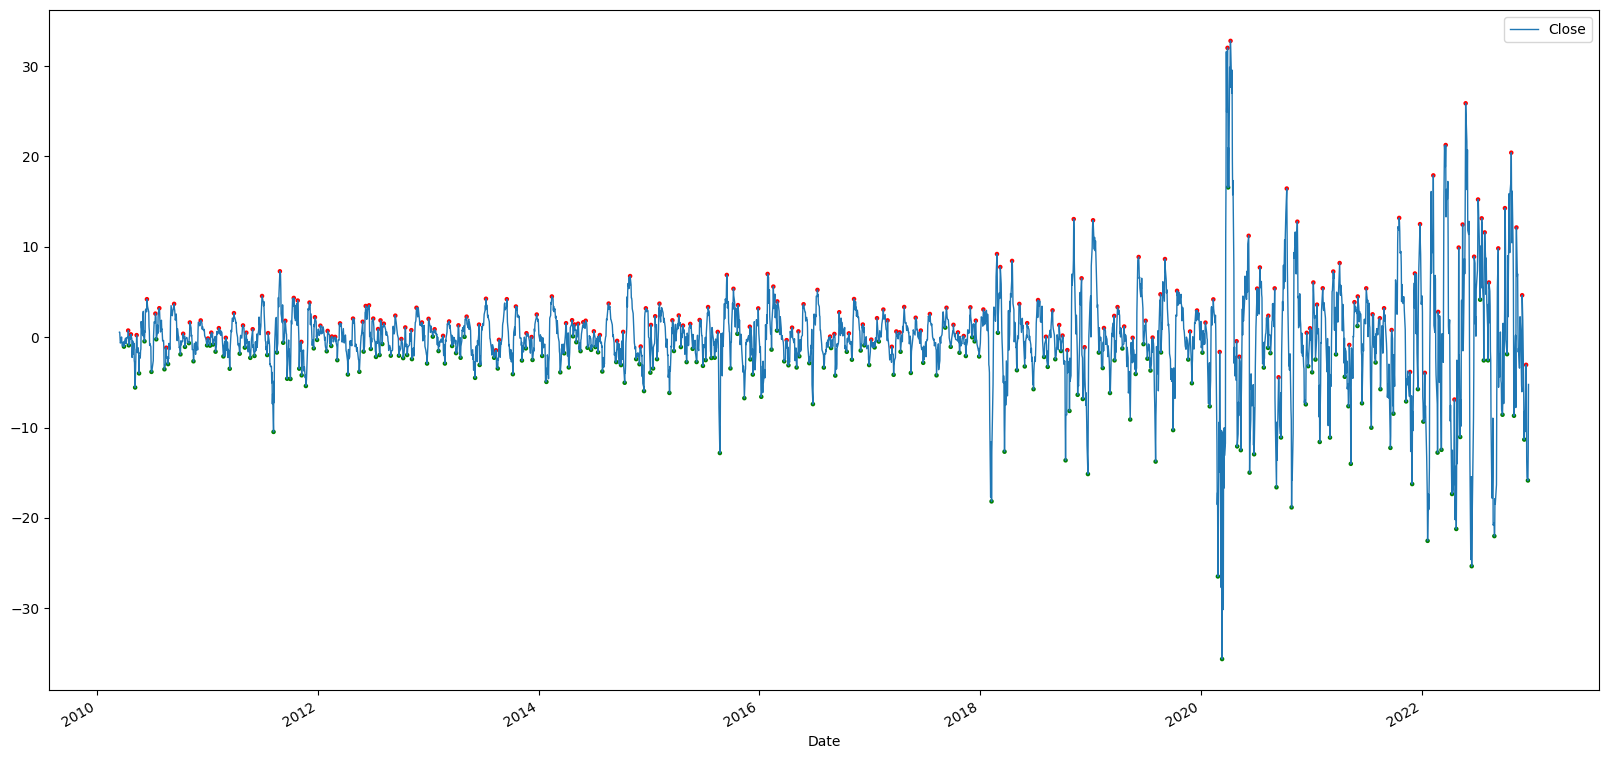

In [17]:
rcParams['figure.figsize'] = 20, 10
plt.figure(figsize=(50, 30))
prices_and_indicators_with_label[["Close"]].plot(kind="line", stacked=False,linewidth=1)
buy_and_sell_preds = prices_and_indicators_with_label.query('Label != 0')
plt.scatter(x = buy_and_sell_preds.index, y = buy_and_sell_preds.Close, s=5, c=pltcolor(buy_and_sell_preds.Label))
plt.show() 

<Figure size 5000x3000 with 0 Axes>

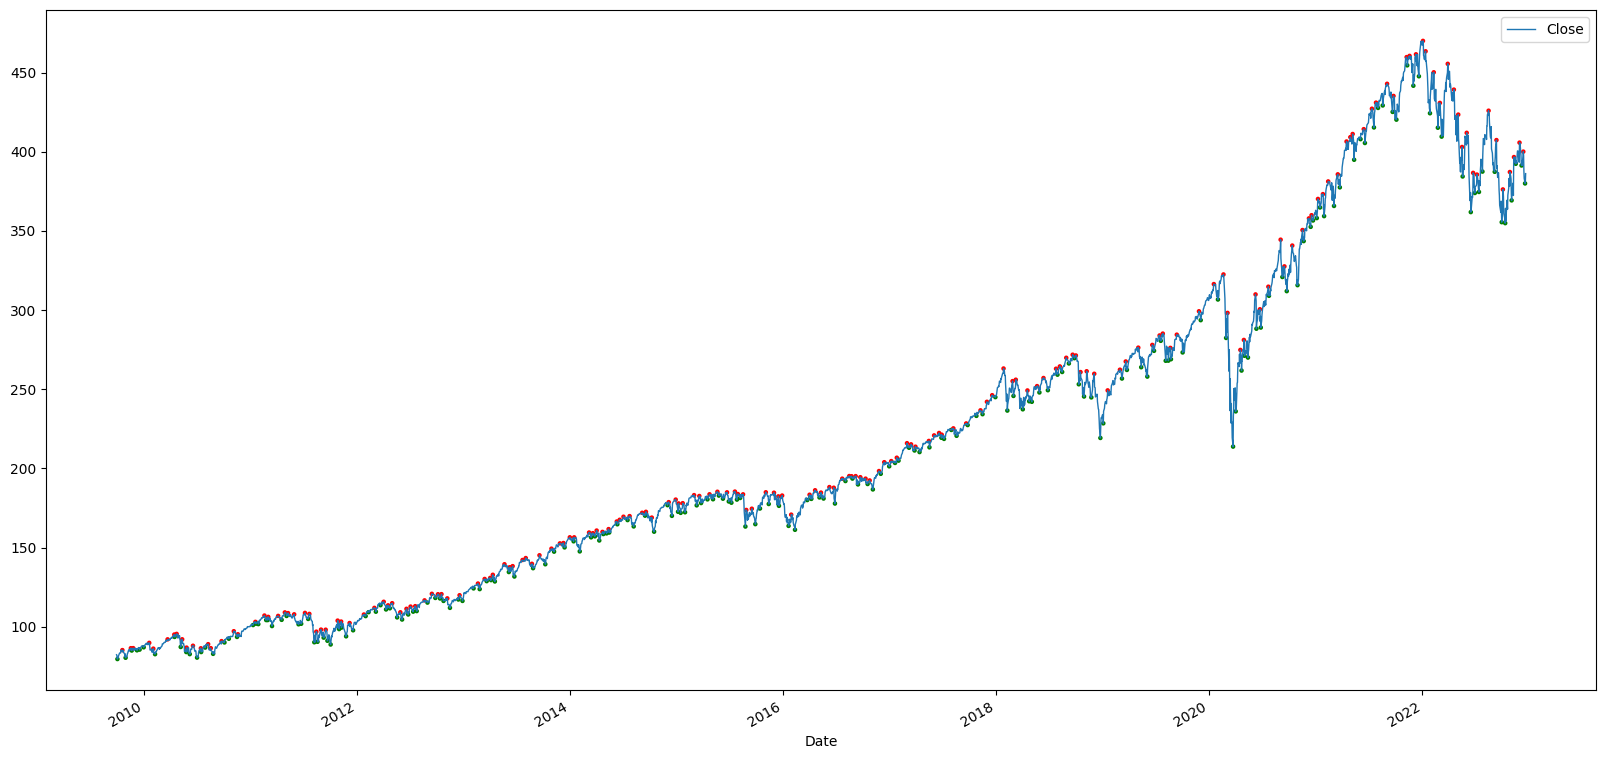

In [18]:
prices_with_label = create_labels(prices)
rcParams['figure.figsize'] = 20, 10
plt.figure(figsize=(50, 30))
prices_with_label[["Close"]].plot(kind="line", stacked=False,linewidth=1)
buy_and_sell_preds = prices_with_label.query('Label != 0')
plt.scatter(x = buy_and_sell_preds.index, y = buy_and_sell_preds.Close, s=5, c=pltcolor(buy_and_sell_preds.Label))
plt.show() 

<h1 style="font-size:30px;"> <center> Creating Train & Test Data </center> </h1>

In [19]:
prices_and_indicators_with_label.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3217 entries, 2010-03-16 00:00:00-04:00 to 2022-12-21 00:00:00-05:00
Columns: 678 entries, Open to Label
dtypes: float64(676), int64(2)
memory usage: 16.7 MB


In [20]:
datas = []

for i in range(5, 13):
    train = prices_and_indicators_with_label.loc[ (prices_and_indicators_with_label.index >= f"{2010+i-5}") & (prices_and_indicators_with_label.index <= f"{2010+i}") ]
    test = prices_and_indicators_with_label.loc[ (prices_and_indicators_with_label.index >= f"{2010+i}") & (prices_and_indicators_with_label.index <= f"{2010+i+1}") ]
    datas.append([train, test])

<h1 style="font-size:30px;"> <center> Feature Selection </center> </h1>

In [21]:
for i in range(len(datas)):
    selected_feature_count = 30
    select = SelectKBest(score_func=f_classif, k = selected_feature_count)
    fitted = select.fit(datas[i][0].iloc[:,:-1], datas[i][0].iloc[:,-1])
    train_features = fitted.transform(datas[i][0].iloc[:,:-1])
    test_features = fitted.transform(datas[i][1].iloc[:,:-1])
    
    selected_features_boolean = select.get_support()
    features = list(datas[i][1].columns[:-1])
    selected_features = []
    for j in range(len(features)):
        if selected_features_boolean[j]:
            selected_features.append(features[j])
    train_label = datas[i][0].Label
    test_label = datas[i][1].Label
    
    datas[i][0] = pd.DataFrame(data=train_features.astype('float32'), columns=selected_features, index=datas[i][0].index)
    datas[i][0]["Label"] = train_label
    datas[i][1] = pd.DataFrame(data=test_features.astype('float32'), columns=selected_features, index=datas[i][1].index)
    datas[i][1]["Label"] = test_label

In [22]:
datas[0][0]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-03-16 00:00:00-04:00,37.759823,-52.957027,55.303886,-24.480358,39.590969,-58.702782,48.988289,-20.818066,41.267673,-58.702782,47.042973,-17.464653,42.725506,41.297218,-14.548986,41.297218,38.376915,37.569023,36.878540,36.294888,35.787033,35.333828,34.935303,34.590458,34.279285,34.003822,33.770393,33.555527,33.351841,33.160347,0
2010-03-17 00:00:00-04:00,37.574413,-51.516197,68.048012,-24.851170,39.432007,-53.441483,54.734360,-21.135984,41.128906,-59.128067,48.483803,-17.742189,42.602779,46.558517,-14.794439,40.871933,43.804871,42.838570,42.014347,41.318626,40.714256,40.175747,39.702824,39.293999,38.925552,38.599728,38.323803,38.070087,37.829792,37.604073,0
2010-03-18 00:00:00-04:00,28.815786,-75.484573,30.962765,-42.368427,31.711252,-78.284187,30.478588,-36.577496,34.253460,-79.146523,24.515427,-31.493080,36.433025,21.715813,-27.133945,20.853479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2010-03-19 00:00:00-04:00,21.402426,-82.355522,19.091749,-57.195148,24.677771,-84.927902,17.840223,-50.644459,27.634136,-86.248909,17.644480,-44.731728,30.236120,15.072097,-39.527760,13.751093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2010-03-22 00:00:00-04:00,29.434330,-56.419041,46.038471,-41.131340,31.283262,-56.809208,46.038471,-37.433475,33.145817,-62.088745,43.580959,-33.708370,34.901649,43.190792,-30.196703,37.911255,28.041206,27.258583,26.583939,26.004461,25.496956,25.044313,24.643572,24.291338,23.973419,23.689272,23.441044,23.213247,23.000113,22.801498,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,71.148735,-34.315544,40.716709,42.297470,69.421677,-33.947502,63.216633,38.843361,67.860947,-33.947502,65.684456,35.721901,66.457924,66.052498,32.915852,66.052498,38.988544,41.151020,43.006172,44.611107,46.010174,47.238285,48.323204,49.287258,50.148571,50.921959,51.619640,52.251770,52.826828,53.351955,0
2014-12-26 00:00:00-05:00,72.136101,-34.939392,70.909248,44.272194,70.322510,-32.595280,43.688625,40.645020,68.696571,-32.245686,65.060608,37.393147,67.241119,67.404724,34.482243,67.754311,41.021004,42.030899,42.956711,43.805649,44.584644,45.300198,45.958344,46.564606,47.124008,47.641087,48.590157,49.690563,50.690536,51.602669,0
2014-12-29 00:00:00-05:00,70.689003,-57.835155,50.273319,41.378006,69.129158,-35.884850,63.719948,38.258316,67.681526,-33.477306,42.164845,35.363049,66.358406,64.115150,32.716816,66.522697,6.394503,7.624710,8.744650,9.765989,10.699148,11.553417,12.337068,13.057448,13.721083,14.333758,14.900604,15.426166,15.914475,16.369112,0


In [23]:
datas[0][1]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,42.521008,-7.703905e+01,23.588970,-14.957986,44.853836,-7.703905e+01,23.588970,-10.292328,46.391594,-7.703905e+01,22.960941,-7.216815,47.422138,22.960941,-5.155725,22.960941,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-05 00:00:00-05:00,27.883104,-9.515692e+01,5.039073,-44.233791,31.124781,-9.524710e+01,4.843075,-37.750439,33.593597,-9.524710e+01,4.843075,-32.812809,35.501453,4.752903,-28.997095,4.752903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-06 00:00:00-05:00,24.230560,-8.982878e+01,11.567267,-51.538879,27.512564,-8.982878e+01,10.501847,-44.974873,30.088749,-8.998261e+01,10.171220,-39.822502,32.132942,10.171220,-35.734116,10.017388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2015-01-07 00:00:00-05:00,43.844292,-5.927761e+01,45.624527,-12.311413,44.374241,-6.055966e+01,44.853710,-11.251518,44.875565,-6.055966e+01,40.722393,-10.248873,45.310097,39.440338,-9.379804,39.440338,72.643707,71.864433,71.200195,70.625977,70.123383,69.678673,69.281441,68.923668,68.599113,68.302826,68.030853,67.779976,67.547585,67.331482,0
2015-01-08 00:00:00-05:00,58.889671,-1.480902e+01,96.452942,17.779341,57.928059,-2.265566e+01,86.654999,15.856119,57.213135,-2.509067e+01,85.190987,14.426271,56.644600,77.344345,13.289203,74.909325,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,2
2015-01-09 00:00:00-05:00,50.927418,-3.386772e+01,71.318367,1.854835,50.845955,-3.498501e+01,71.318367,1.691908,50.813629,-4.097331e+01,66.132286,1.627255,50.794083,65.014992,1.588167,59.026691,75.166275,75.074524,74.992950,74.919579,74.852905,74.791779,74.735298,74.682777,74.633667,74.587532,74.544022,74.502853,74.463783,74.426620,0
2015-01-12 00:00:00-05:00,44.741402,-4.808068e+01,51.919319,-10.517194,45.298351,-5.185612e+01,51.919319,-9.403300,45.765823,-5.266950e+01,51.919319,-8.468350,46.151722,48.143883,-7.696554,47.330502,54.978027,54.753456,54.551266,54.367519,54.199169,54.043839,53.899666,53.765167,53.639153,53.520649,53.408855,53.303108,53.202835,53.107552,0
2015-01-13 00:00:00-05:00,43.234234,-5.285278e+01,28.193176,-13.531534,43.950222,-5.285278e+01,47.147224,-12.099553,44.541306,-5.628120e+01,47.147224,-10.917392,45.026901,47.147224,-9.946198,43.718803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-14 00:00:00-05:00,39.825134,-6.324699e+01,32.366753,-20.349730,40.918804,-6.324699e+01,32.366753,-18.162388,41.800716,-6.324699e+01,36.753010,-16.398567,42.518951,36.753010,-14.962095,36.753010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [24]:
for i in range(len(datas)):
    abs_scaler = MaxAbsScaler()
    abs_scaler.fit(datas[i][0])
    scaled_train = abs_scaler.transform(datas[i][0])
    scaled_test = abs_scaler.transform(datas[i][1])
    datas[i][0] = pd.DataFrame(data=scaled_train, columns=datas[i][0].columns, index=datas[i][0].index)
    datas[i][0]["Label"] = datas[i][0]["Label"] * 2
    datas[i][1] = pd.DataFrame(data=scaled_test, columns=datas[i][1].columns, index=datas[i][1].index)
    datas[i][1]["Label"] = datas[i][1]["Label"] * 2

In [25]:
datas[0][0]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-03-16 00:00:00-04:00,0.445704,-0.529570,0.553039,-0.350292,0.481730,-0.587028,0.489883,-0.323413,0.516430,-0.587028,0.470430,-0.291958,0.548759,0.412972,-0.259976,0.412972,0.383769,0.375690,0.368785,0.362949,0.357870,0.353338,0.349353,0.345905,0.342793,0.340038,0.337704,0.335555,0.333518,0.331603,0.0
2010-03-17 00:00:00-04:00,0.443516,-0.515162,0.680480,-0.355598,0.479796,-0.534415,0.547344,-0.328352,0.514693,-0.591281,0.484838,-0.296598,0.547183,0.465585,-0.264362,0.408719,0.438049,0.428386,0.420143,0.413186,0.407143,0.401757,0.397028,0.392940,0.389256,0.385997,0.383238,0.380701,0.378298,0.376041,0.0
2010-03-18 00:00:00-04:00,0.340132,-0.754846,0.309628,-0.606254,0.385853,-0.782842,0.304786,-0.568240,0.428653,-0.791465,0.245154,-0.526473,0.467940,0.217158,-0.484857,0.208535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2010-03-19 00:00:00-04:00,0.252627,-0.823555,0.190917,-0.818411,0.300271,-0.849279,0.178402,-0.786773,0.345818,-0.862489,0.176445,-0.747784,0.388348,0.150721,-0.706322,0.137511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2010-03-22 00:00:00-04:00,0.347433,-0.564190,0.460385,-0.588552,0.380645,-0.568092,0.460385,-0.581538,0.414792,-0.620887,0.435810,-0.563506,0.448271,0.431908,-0.539585,0.379113,0.280412,0.272586,0.265839,0.260045,0.254970,0.250443,0.246436,0.242913,0.239734,0.236893,0.234410,0.232132,0.230001,0.228015,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,0.839816,-0.343155,0.407167,0.605239,0.844701,-0.339475,0.632166,0.603441,0.849222,-0.339475,0.656845,0.597166,0.853575,0.660525,0.588173,0.660525,0.389885,0.411510,0.430062,0.446111,0.460102,0.472383,0.483232,0.492873,0.501486,0.509220,0.516196,0.522518,0.528268,0.533520,0.0
2014-12-26 00:00:00-05:00,0.851470,-0.349394,0.709092,0.633495,0.855662,-0.325953,0.436886,0.631430,0.859679,-0.322457,0.650606,0.625105,0.863634,0.674047,0.616163,0.677543,0.410210,0.420309,0.429567,0.438056,0.445846,0.453002,0.459583,0.465646,0.471240,0.476411,0.485902,0.496906,0.506905,0.516027,0.0
2014-12-29 00:00:00-05:00,0.834389,-0.578352,0.502733,0.592082,0.841142,-0.358848,0.637199,0.594352,0.846977,-0.334773,0.421648,0.591167,0.852297,0.641152,0.584617,0.665227,0.063945,0.076247,0.087446,0.097660,0.106991,0.115534,0.123371,0.130574,0.137211,0.143338,0.149006,0.154262,0.159145,0.163691,0.0


In [26]:
datas[0][1]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,0.501904,-7.703905e-01,0.235890,-0.214035,0.545767,-7.703905e-01,0.235890,-0.159894,0.580552,-7.703905e-01,0.229609,-0.120644,0.609082,0.229609,-0.092128,0.229609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-05 00:00:00-05:00,0.329123,-9.515692e-01,0.050391,-0.632946,0.378717,-9.524710e-01,0.048431,-0.586462,0.420395,-9.524710e-01,0.048431,-0.548535,0.455975,0.047529,-0.518149,0.047529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-06 00:00:00-05:00,0.286009,-8.982878e-01,0.115673,-0.737475,0.334764,-8.982878e-01,0.105018,-0.698695,0.376535,-8.998261e-01,0.101712,-0.665716,0.412710,0.101712,-0.638533,0.100174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2015-01-07 00:00:00-05:00,0.517523,-5.927761e-01,0.456245,-0.176165,0.539932,-6.055966e-01,0.448537,-0.174795,0.561580,-6.055966e-01,0.407224,-0.171331,0.581956,0.394403,-0.167608,0.394403,0.726437,0.718644,0.712002,0.706260,0.701234,0.696787,0.692814,0.689237,0.685991,0.683028,0.680309,0.677800,0.675476,0.673315,0.0
2015-01-08 00:00:00-05:00,0.695114,-1.480902e-01,0.964529,0.254406,0.704850,-2.265566e-01,0.866550,0.246328,0.715974,-2.509067e-01,0.851910,0.241165,0.727534,0.773443,0.237465,0.749093,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0
2015-01-09 00:00:00-05:00,0.601130,-3.386772e-01,0.713184,0.026541,0.618678,-3.498501e-01,0.713184,0.026284,0.635890,-4.097331e-01,0.661323,0.027203,0.652391,0.650150,0.028379,0.590267,0.751663,0.750745,0.749930,0.749196,0.748529,0.747918,0.747353,0.746828,0.746337,0.745875,0.745440,0.745029,0.744638,0.744266,0.0
2015-01-12 00:00:00-05:00,0.528113,-4.808068e-01,0.519193,-0.150492,0.551176,-5.185612e-01,0.519193,-0.146082,0.572721,-5.266950e-01,0.519193,-0.141566,0.592765,0.481439,-0.137530,0.473305,0.549780,0.547535,0.545513,0.543675,0.541992,0.540438,0.538997,0.537652,0.536392,0.535206,0.534089,0.533031,0.532028,0.531076,0.0
2015-01-13 00:00:00-05:00,0.510322,-5.285278e-01,0.281932,-0.193624,0.534772,-5.285278e-01,0.471472,-0.187969,0.557397,-5.628120e-01,0.471472,-0.182507,0.578318,0.471472,-0.177729,0.437188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-14 00:00:00-05:00,0.470083,-6.324699e-01,0.323668,-0.291186,0.497887,-6.324699e-01,0.323668,-0.282157,0.523101,-6.324699e-01,0.367530,-0.274136,0.546107,0.367530,-0.267358,0.367530,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


<h1 style="font-size:30px;"> <center> Controling Null Values </center> </h1>

In [27]:
total_na_count = 0
for data in datas:
    total_na_count += number_null_and_nan(data[0])
    total_na_count += number_null_and_nan(data[1])
print(f"Total null and nan values = {total_na_count}")

Total null and nan values = 0


<h1 style="font-size:40px;"> <center> MODEL INITIALIZATIONS </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [28]:
def create_model_MLP(trial=None, activation_func="swish", dropout_rate = 0.2, optimizer_algo = "adam"):
    MLP = Sequential()
    MLP.add(Dense(64, input_shape=(30,), activation=activation_func, kernel_initializer=tf.keras.initializers.HeUniform()))
    MLP.add(BatchNormalization())
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(3, activation='softmax'))
    MLP.compile(loss="categorical_crossentropy", optimizer=optimizer_algo, metrics=["accuracy","Precision","Recall","AUC",tfa.metrics.F1Score(num_classes=3, average="macro")])
    return MLP

In [29]:
set_random_seed()

start_time = time.time()
predictions = []
f1_scores = []

for i in range(len(datas)):
    OUTPUT_PATH = "./outputs"
    es = EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience=20, min_delta=1e-2)
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,f"best_CNN_model-{i+1}.h5"), monitor='val_f1_score', verbose=0, 
                          save_best_only=True, save_weights_only=False, mode='max')
    
    val_split_point = int(0.5*len(datas[i][0]))
    X_train = datas[i][0][:val_split_point].iloc[:, :-1]
    y_train = tf.keras.utils.to_categorical(datas[i][0][:val_split_point].iloc[:, -1], num_classes = 3)
    X_val = datas[i][0][val_split_point:].iloc[:, :-1]
    y_val = tf.keras.utils.to_categorical(datas[i][0][val_split_point:].iloc[:, -1], num_classes = 3)
    X_test = datas[i][1].iloc[:, :-1]
    y_test = datas[i][1].iloc[:, -1]
    
    model = create_model_MLP()
    model.fit(X_train, y_train, batch_size=64, 
                        epochs=1, verbose=0, callbacks=[es, mcp], 
                        validation_data=(X_val, y_val), 
                        class_weight={0:1, 1:10, 2:10})
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=-1)
    predictions.append(y_pred)
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    
print(f"\nAverage f1-macro score: {np.mean(f1_scores)}\n")
minutes = round(int(time.time() - start_time)/60, 2)
print(f"\nCompleted in {minutes} minutes\n")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
8/8 [==============================] - 0s 2ms/step

Average f1-macro score: 0.26267906681764475


Completed in 0.43 minutes



<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

<h1 style="font-size:40px;"> <center> HYPERPARAMETER TUNING </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [30]:
set_random_seed()
start_time = time.time()

def objective(trial):
    activation_func = trial.suggest_categorical(name="activation_func", choices = ["relu", "selu", "swish"])
    dropout_rate = trial.suggest_categorical("drop_out_rate", [0.1, 0.2, 0.3])
    optimizer_algo = trial.suggest_categorical("optimizer_algorithm", ["adam", "adadelta", "rmsprop"])
    batch = trial.suggest_categorical("batch_size", [32, 64, 256])
    #epoch_num = trial.suggest_categorical("epoch_number", [50, 100, 200])
    lr_max = trial.suggest_categorical("learning_rate_max", [1e-1,1e-2,1e-3,1e-4])

    model = create_model_MLP(trial, activation_func, dropout_rate, optimizer_algo)

    f1_scores = []

    for i in range(len(datas)):
        OUTPUT_PATH = "./outputs"
        es = EarlyStopping(monitor='f1_score', mode='max', verbose=1, patience=20, min_delta=1e-2)
        mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,f"best_CNN_model-{i+1}.h5"), monitor='f1_score', verbose=0, 
                                  save_best_only=True, save_weights_only=False, mode='max')

        val_split_point = int(0.5*len(datas[i][0]))
        X_train = datas[i][0][:val_split_point].iloc[:, :-1]
        y_train = tf.keras.utils.to_categorical(datas[i][0][:val_split_point].iloc[:, -1], num_classes = 3)
        X_val = datas[i][0][val_split_point:].iloc[:, :-1]
        y_val = datas[i][0][val_split_point:].iloc[:, -1]

        model.fit(X_train, y_train, batch_size=batch, 
                                epochs=1, verbose=0, callbacks=[es, mcp], 
                                class_weight={0:1, 1:10, 2:10})
        y_pred = model.predict(X_val)
        y_pred = y_pred.argmax(axis=-1)
        f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    return np.mean(f1_scores)

study = optuna.create_study(study_name="MLP_Bayesian_Optimization", direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=5)
trial = study.best_trial

print("\n------------------------------------------")
print('Best F1 Macro: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
minutes = round(int(time.time() - start_time)/60, 2)
print(f"\nCompleted in {minutes} minutes")

[I 2023-01-24 18:55:49,423] A new study created in memory with name: MLP_Bayesian_Optimization


20/20 [==============================] - 0s 2ms/step


[I 2023-01-24 18:55:54,805] Trial 0 finished with value: 0.16754082006519522 and parameters: {'activation_func': 'selu', 'drop_out_rate': 0.1, 'optimizer_algorithm': 'adadelta', 'batch_size': 256, 'learning_rate_max': 0.1}. Best is trial 0 with value: 0.16754082006519522.


20/20 [==============================] - 0s 2ms/step


[I 2023-01-24 18:55:59,738] Trial 1 finished with value: 0.42680402110818105 and parameters: {'activation_func': 'selu', 'drop_out_rate': 0.2, 'optimizer_algorithm': 'rmsprop', 'batch_size': 32, 'learning_rate_max': 0.001}. Best is trial 1 with value: 0.42680402110818105.


20/20 [==============================] - 0s 2ms/step


[I 2023-01-24 18:56:04,509] Trial 2 finished with value: 0.44502453161801125 and parameters: {'activation_func': 'swish', 'drop_out_rate': 0.1, 'optimizer_algorithm': 'adam', 'batch_size': 256, 'learning_rate_max': 0.01}. Best is trial 2 with value: 0.44502453161801125.


20/20 [==============================] - 0s 2ms/step


[I 2023-01-24 18:56:09,718] Trial 3 finished with value: 0.17588188184387116 and parameters: {'activation_func': 'swish', 'drop_out_rate': 0.2, 'optimizer_algorithm': 'adadelta', 'batch_size': 256, 'learning_rate_max': 0.001}. Best is trial 2 with value: 0.44502453161801125.


20/20 [==============================] - 0s 2ms/step


[I 2023-01-24 18:56:15,187] Trial 4 finished with value: 0.4106815912038047 and parameters: {'activation_func': 'selu', 'drop_out_rate': 0.3, 'optimizer_algorithm': 'adam', 'batch_size': 32, 'learning_rate_max': 0.1}. Best is trial 2 with value: 0.44502453161801125.



------------------------------------------
Best F1 Macro: 0.44502453161801125
Best hyperparameters: {'activation_func': 'swish', 'drop_out_rate': 0.1, 'optimizer_algorithm': 'adam', 'batch_size': 256, 'learning_rate_max': 0.01}

Completed in 0.42 minutes


<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

<h1 style="font-size:40px;"> <center> FINANCIAL EVALUATION </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>